### Number of cliks prediction
---

In [42]:
import pandas as pd
import requests
from io import StringIO

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor,  BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import 



#### 1- EDA

In [2]:
def loading_data(file_url):
    """
    Reading data from a given url
    
    inputs:
    ------
    url : link to the data
    returns
    -----:
    data : data frame  
    """
    
    file_id = file_url.split('/')[-2]
    dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
    url = requests.get(dwn_url).text
    csv_raw = StringIO(url)
    df = pd.read_csv(csv_raw)
    
    
    return df

In [3]:
# Let's load the training data

In [4]:
hotel_url = 'https://drive.google.com/file/d/1c85h1hzgzLvAeYSh-EVpY6Gz3dYLsd6R/view?usp=sharing'
hotel_data = loading_data(hotel_url )

In [5]:
# first we will have a quick look at the data head and tail
hotel_data.head()

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
0,9.767406e+10,134520.0,70.0,2.0,1199.0,77.0,4.0,861.0,17.550,81.64,18.0,0
1,9.768889e+10,133876.0,67.0,3.0,12585.0,90.0,4.0,4371.0,17.383,189.38,28.0,4
2,9.811544e+10,133732.0,39.0,3.0,23491.0,83.0,3.0,1005.0,16.438,57.63,27.0,44
3,9.824279e+10,43772.0,59.0,8.0,3291.0,73.0,2.0,3084.0,7.000,72.16,2.0,4
4,9.833438e+10,50532.0,66.0,1.0,288.0,80.0,0.0,603.0,12.564,173.25,0.0,10


In [6]:
# we see that we have only numerical predictors

In [7]:
hotel_data.tail()

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
396482,1.277185e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.333,103.07,0.0,0
396483,6.841541e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000,44.00,0.0,0
396484,8.649506e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.400,42.78,29.0,4
396485,1.293587e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.143,96.23,36.0,4
396486,1.609336e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.833,65.69,5.0,4


In [8]:
# We can see right a way that our data has Nan in it which indicate we will need some prepocessing and cleaning

In [9]:
# let's get a quick description of the dat set 

hotel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396487 entries, 0 to 396486
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   hotel_id            396487 non-null  float64
 1   city_id             395979 non-null  float64
 2   content_score       395979 non-null  float64
 3   n_images            395978 non-null  float64
 4   distance_to_center  395958 non-null  float64
 5   avg_rating          286089 non-null  float64
 6   stars               395925 non-null  float64
 7   n_reviews           395958 non-null  float64
 8   avg_rank            396487 non-null  float64
 9   avg_price           396317 non-null  float64
 10  avg_saving_percent  396317 non-null  float64
 11  n_clicks            396487 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 36.3 MB


> We have 12 predictors, alll of them are float except the n_clicks which is integer
> The data contains 396478 row. From the comparision of the counts, it appears that `avg_rating` has the maximum number of NaNs.

In [10]:
# Now let's have a look at the statistics of values
hotel_data.describe()

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
count,3.964870e+05,395979.000000,395979.000000,3.959780e+05,3.959580e+05,286089.000000,395925.000000,395958.000000,396487.000000,396317.000000,396317.000000,396487.000000
mean,1.326304e+11,149193.465376,50.992795,2.593212e+02,1.634383e+04,81.616525,1.159659,913.667419,14.694502,109.332048,7.179601,13.781980
std,1.033722e+11,219189.285044,11.563444,1.731682e+04,2.752200e+05,6.025140,1.619713,2432.494160,5.604578,148.198851,13.081529,123.572896
min,1.557962e+08,2.000000,7.000000,-1.000000e+00,0.000000e+00,34.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000
25%,4.062255e+10,32014.000000,45.000000,0.000000e+00,5.440000e+02,79.000000,0.000000,0.000000,11.091000,51.050000,0.000000,0.000000
50%,1.087280e+11,55122.000000,53.000000,1.000000e+00,1.516000e+03,83.000000,0.000000,189.000000,15.000000,77.650000,0.000000,0.000000
75%,2.281935e+11,137464.000000,59.000000,2.000000e+00,4.163000e+03,86.000000,3.000000,777.000000,18.375000,120.930000,10.000000,2.000000
max,3.237114e+11,878736.000000,81.000000,2.393911e+06,1.834155e+07,97.000000,5.000000,283089.000000,100.000000,8000.000000,99.000000,13742.000000


 > There are a couple of interesting observations:
 - Content score ranging from 7 to 71 with a mean of 50.99
 - We have some negative n_images which has to be removed
 - Median avg_rating is 83.0 but median stars is 0.
 - We have a median of189 for n_reviews
 - The avg_price ranges from 4 to 8000 and the avg_saving ranges from 0 to 99%
 - Hotels have avg n_clicks of 13.78

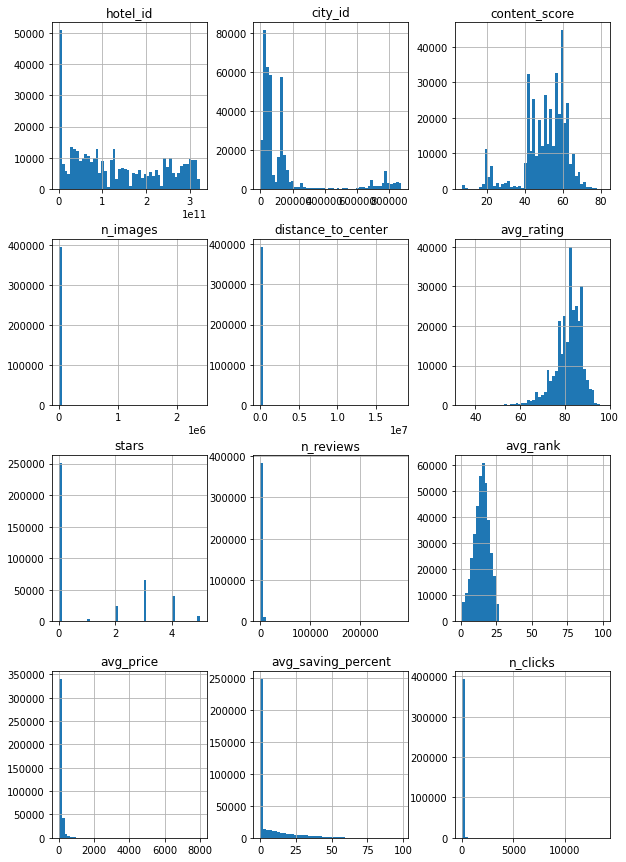

In [11]:
# Now let's look at a histogram for the data

hotel_data.hist(bins = 50, figsize=(10,15))
plt.show()

> Predictors vary significantly when it comes to scaling which will require appropriate treatment

#### Initial Modeling

In [14]:
# for our initial model we will just drop the rows that have nans, this is initial approach, we will later deal with how to fill those nans
initial_model_data = hotel_data.copy()

y_inital_model= initial_model_data['n_clicks']
X_initial_model = initial_model_data.drop(columns = ['n_clicks'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_initial_model,y_inital_model,test_size = 0.2, random_state = 2020)

In [20]:
y_train

318555    2
242458    0
47301     0
197488    0
75542     0
         ..
20039     0
18523     0
375414    0
192904    0
303968    0
Name: n_clicks, Length: 317189, dtype: int64

In [36]:
# creating initial pipe_line

numerical_features = list(X_train.columns)
    
numerical_transformer = Pipeline(steps = [('imputer',SimpleImputer()),
                                         ('scaler',StandardScaler())])

preprocessor = ColumnTransformer(transformers = [('num',numerical_transformer,numerical_features)])

regressor = GradientBoostingRegressor()

regressor_pipeline = Pipeline(steps = [('preprocessor',preprocessor),
                                      ('regressor',regressor)])



In [45]:
def get_ensemble_models():
    rf =RandomForestRegressor(n_estimators=51,min_samples_leaf=5,min_samples_split=3)
    bagg = BaggingRegressor(n_estimators=51,random_state=42)
    extra = ExtraTreesRegressor(n_estimators=51,random_state=42)
    ada = AdaBoostRegressor(n_estimators=51,random_state=42)
    grad = GradientBoostingRegressor(n_estimators=51,random_state=42)
    classifier_list = [rf,bagg,extra,ada,grad]
    classifier_name_list = ['Random Forests','Bagging','Extra Trees','AdaBoost','Gradient Boost']
    return classifier_list,classifier_name_list
    
classifier_list, classifier_name_list = get_ensemble_models()

for classifier,classifier_name in zip(classifier_list,classifier_name_list):
    regressor_pipeline = Pipeline(steps = [('preprocessor',preprocessor),
                                      ('regressor',classifier)])
    regressor_pipeline.fit(X_train,y_train)
    print('Results for ',classifier_name)
    print('Training score = ',regressor_pipeline.score(X_train,y_train))
    print('Test score = ',regressor_pipeline.score(X_test,y_test))
    print('______________________________________________________')


Results for  Random Forests
Training score =  0.6282447292854614
Teest score =  0.3916444218251688
______________________________________________________
Results for  Bagging
Training score =  0.9059835059398292
Teest score =  0.37428464494845304
______________________________________________________
Results for  Extra Trees
Training score =  1.0
Teest score =  0.36239732435715
______________________________________________________
Results for  AdaBoost
Training score =  -4.357061042708757
Teest score =  -5.050437097765885
______________________________________________________
Results for  Gradient Boost
Training score =  0.32896398746836975
Teest score =  0.31209704614969813
______________________________________________________
